# Trabalho de Sobredispersão em Modelos de Contagem
1. Análise exploratória dos dados
2. Ajuste do modelo de Poisson
3. Teste de sobredispersão
4. Ajuste do modelo binomial negativo
5. Análise de excesso de zeros e comparação de modelos

# RecreationDemand

## Descrição Geral

O conjunto de dados `RecreationDemand` contém informações coletadas em 1980 por meio de uma pesquisa com 2.000 proprietários de barcos de lazer registrados em 23 condados do leste do Texas, EUA. A pesquisa visava entender a demanda por viagens recreativas de barco ao Lago Somerville, além de coletar dados sobre características dos entrevistados e custos associados a visitas a outros lagos da região.

O conjunto é frequentemente utilizado em análises econométricas de dados de contagem, como modelos de Poisson, binomial negativa, modelos zero-inflados e modelos hurdle.

## Estrutura dos Dados

* **Observações**: 659
* **Variáveis**: 8

## Descrição das Variáveis

- **trips**: Número de viagens recreativas de barco realizadas ao Lago Somerville.
- **quality**: Avaliação subjetiva da qualidade das instalações do lago, em uma escala de 1 a 5. Para indivíduos que não visitaram o lago, o valor é 0.
- **ski**: Indica se o indivíduo praticou esqui aquático no lago (`sim` ou `não`).
- **income**: Renda anual da família do entrevistado, em milhares de dólares americanos (USD).
- **userfee**: Indica se o indivíduo pagou uma taxa anual de uso no Lago Somerville (`sim` ou `não`).
- **costC**: Despesa estimada ao visitar o Lago Conroe, em dólares americanos (USD).
- **costS**: Despesa estimada ao visitar o Lago Somerville, em dólares americanos (USD).
- **costH**: Despesa estimada ao visitar o Lago Houston, em dólares americanos (USD).

### Observações

- A variável "quality" inclui o valor 0 para não visitantes, o que pode reduzir sua média, conforme explicado em Seller et al. (1985).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pprint import pprint

In [2]:
recreation_demand = sm.datasets.get_rdataset("RecreationDemand", "AER", cache=True)

## 1. Análise Exploratória dos Dados

In [3]:
data = recreation_demand.data
# data.to_csv("./data/RecreationDemand.csv", index=False)
data.head()

,trips,quality,ski,income,userfee,costC,costS,costH
0,0,0,yes,4,no,67.59,68.620,76.800
1,0,0,no,9,no,68.86,70.936,84.780
2,0,0,yes,5,no,58.12,59.465,72.110
3,0,0,no,2,no,15.79,13.750,23.680
4,0,0,yes,3,no,24.02,34.033,34.547


Começaremos a análise identificando os tipos de variáveis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   trips    659 non-null    int64  
 1   quality  659 non-null    int64  
 2   ski      659 non-null    object 
 3   income   659 non-null    int64  
 4   userfee  659 non-null    object 
 5   costC    659 non-null    float64
 6   costS    659 non-null    float64
 7   costH    659 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 41.3+ KB


In [5]:
data.describe()

,trips,quality,income,costC,costS,costH
count,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000
mean,2.244310,1.418816,3.852807,55.423704,59.928053,55.990303
std,6.292475,1.811986,1.851937,46.682648,46.376676,46.133211
min,0.000000,0.000000,1.000000,4.340000,4.767000,5.700000
25%,0.000000,0.000000,3.000000,28.240000,33.312000,28.963500
50%,0.000000,0.000000,3.000000,41.190000,47.000000,42.380000
75%,2.000000,3.000000,5.000000,69.675000,72.573500,68.560000
max,88.000000,5.000000,9.000000,493.770000,491.547000,491.049000


In [6]:
data["quality"].value_counts().sort_index()

quality
0    374
1     32
2     31
3    101
4     67
5     54
Name: count, dtype: int64

In [7]:
data["income"].value_counts().sort_index()

income
1     42
2     87
3    206
4    144
5     83
6     38
7     17
8     11
9     31
Name: count, dtype: int64

In [8]:
data["ski"].value_counts().sort_index()

ski
no     417
yes    242
Name: count, dtype: int64

In [9]:
data["userfee"].value_counts().sort_index()

userfee
no     646
yes     13
Name: count, dtype: int64

Agora visualizaremos a distribuição de cada uma delas

In [10]:
# used_cols = [col for col in data.columns if col not in ["ski", "userfee"]]

data_correlation = data.copy()

data_correlation["ski"] = data_correlation["ski"].apply(lambda x: int(x == "yes"))
data_correlation["userfee"] = data_correlation["userfee"].apply(lambda x: int(x == "yes"))

correlation_matrix = data_correlation.corr()

In [11]:
data_correlation["costC_log"] = np.log(data_correlation["costC"] + 1)
data_correlation["costS_log"] = np.log(data_correlation["costS"] + 1)
data_correlation["costH_log"] = np.log(data_correlation["costH"] + 1)

In [12]:
trips_mean = data[trips := "trips"].mean()
trips_var = data[trips].var()
print(f"Média de trips: {trips_mean:.2f}")
print(f"Variância de trips: {trips_var:.2f}")

Média de trips: 2.24
Variância de trips: 39.60


In [13]:
np.abs(data_correlation.corr()["trips"]).sort_values(ascending=False)

trips        1.000000
quality      0.386351
userfee      0.279107
costS_log    0.222033
costS        0.123704
ski          0.079041
income       0.060030
costC        0.042213
costH        0.020512
costH_log    0.019436
costC_log    0.017639
Name: trips, dtype: float64

In [14]:
# Paleta de cores
sns.set(style="whitegrid", palette="gist_earth")

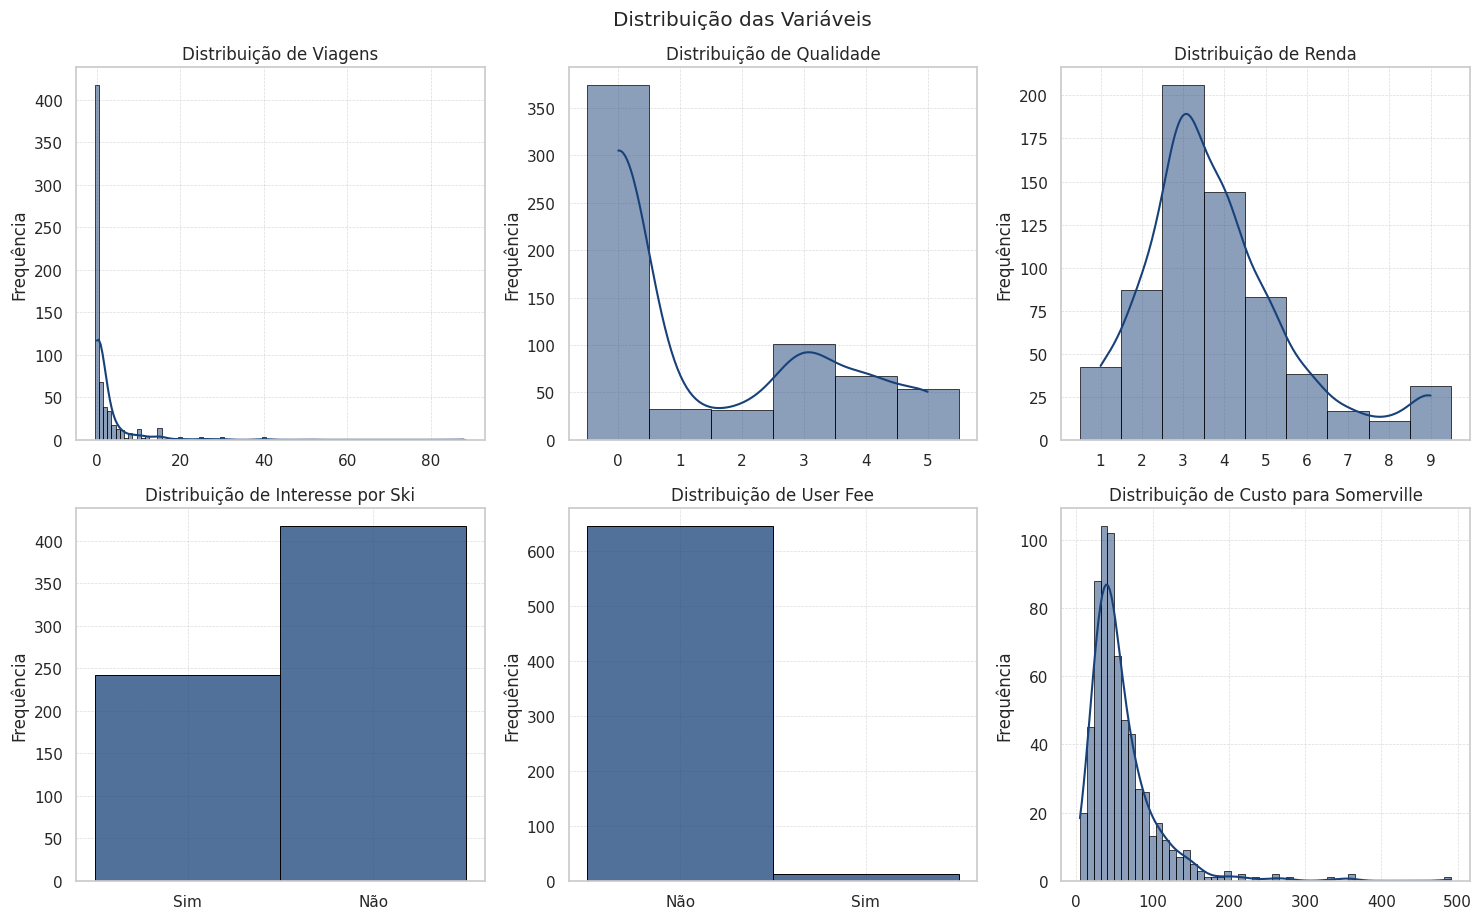

In [15]:
# Criar subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 9))

# Lista de colunas e títulos
columns = ["trips", "quality", "income", "ski", "userfee", "costS"]
titles = [
    "Distribuição de Viagens",
    "Distribuição de Qualidade",
    "Distribuição de Renda",
    "Distribuição de Interesse por Ski",
    "Distribuição de User Fee",
    "Distribuição de Custo para Somerville",
]

# Plot para cada variável
for i, (col, title) in enumerate(zip(columns, titles)):
    row, col_idx = divmod(i, 3)
    ax = axs[row, col_idx]

    # Histograma
    if col in ["ski", "userfee"]:
        sns.histplot(data[col], discrete=True, ax=ax, edgecolor="black", linewidth=0.7)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(["Não", "Sim"] if col == "userfee" else ["Sim", "Não"])
    else:
        sns.histplot(
            data[col],
            kde=True,
            discrete=True if data[col].dtype != "float" else False,
            ax=ax,
            edgecolor="black",
            linewidth=0.5,
        )
        if col == "income":
            ax.set_xticks(range(1, 10))

    ax.set_title(title, fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("Frequência")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)


# Layout final
plt.tight_layout()
plt.suptitle("Distribuição das Variáveis", y=1.02)

plt.savefig("images/distribuicoes_variaveis.png", dpi=300)

plt.show()

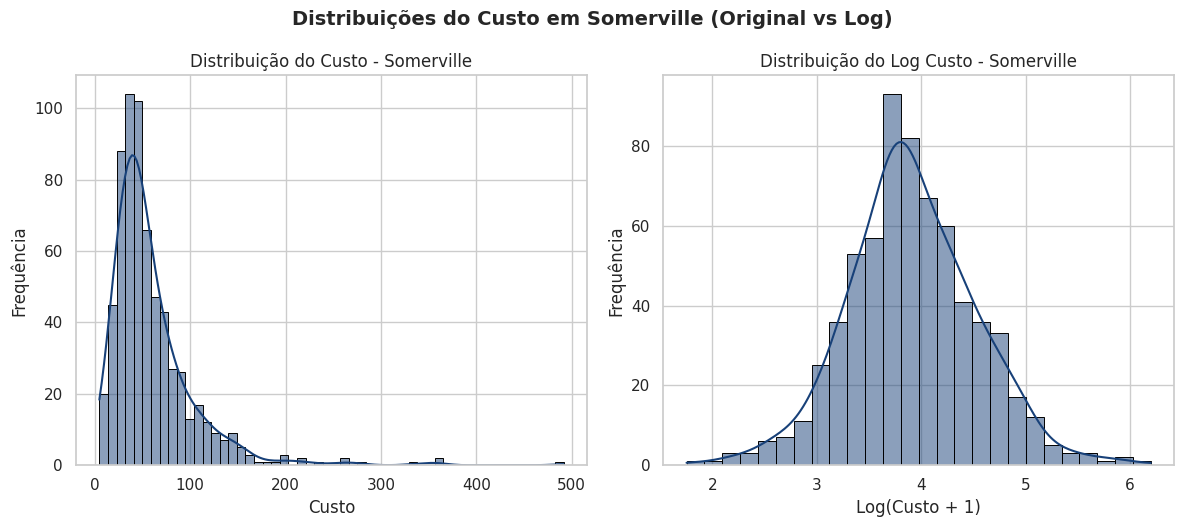

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    data["costS"],
    kde=True,
    ax=axs[0],
    edgecolor="black",
    linewidth=0.7,
)
axs[0].set_title("Distribuição do Custo - Somerville", fontsize=12)
axs[0].set_xlabel("Custo")
axs[0].set_ylabel("Frequência")

sns.histplot(
    np.log(data["costS"] + 1),
    kde=True,
    ax=axs[1],
    edgecolor="black",
    linewidth=0.7,
)
axs[1].set_title("Distribuição do Log Custo - Somerville", fontsize=12)
axs[1].set_xlabel("Log(Custo + 1)")
axs[1].set_ylabel("Frequência")

plt.tight_layout()
plt.suptitle(
    "Distribuições do Custo em Somerville (Original vs Log)",
    fontsize=14,
    fontweight="bold",
    y=1.05,
)
plt.savefig("images/comparacao_custo_somerville.png", dpi=300)
plt.show()

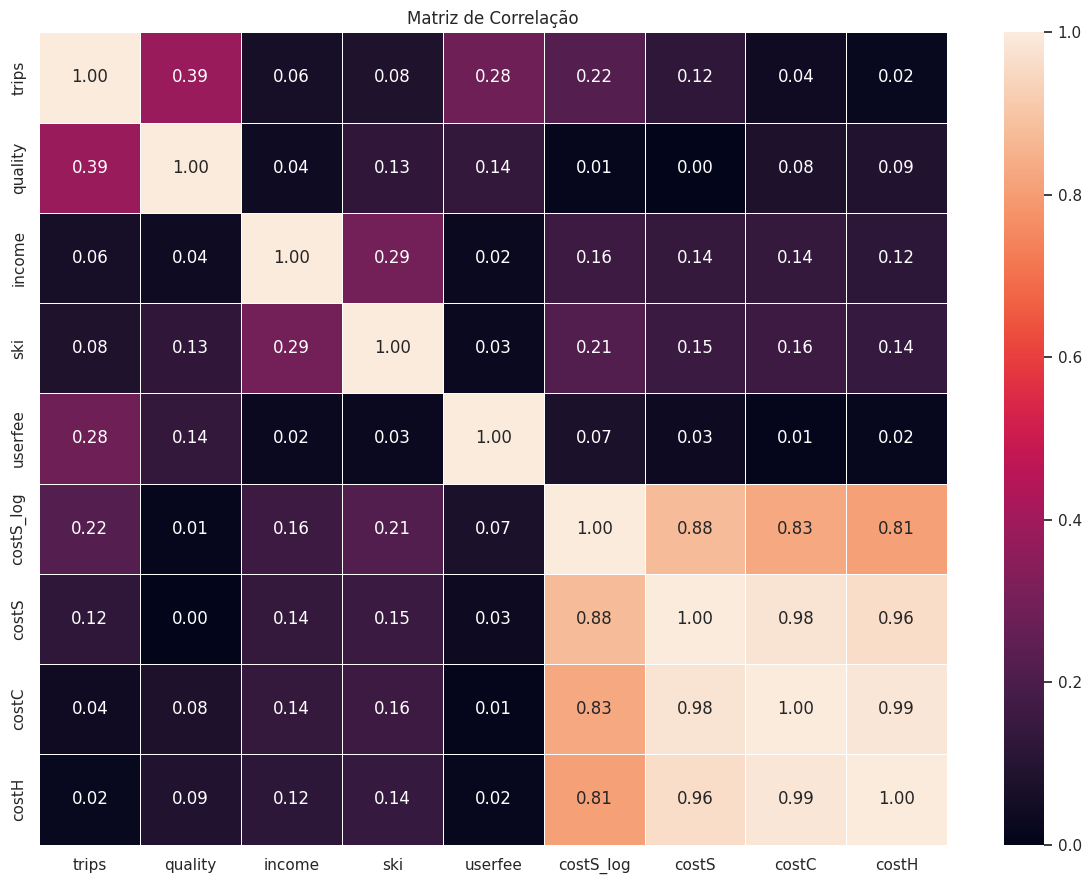

In [17]:
plt.figure(figsize=(12, 9))

cols = [
    "trips",
    "quality",
    "income",
    "ski",
    "userfee",
    "costS_log",
    "costS",
    "costC",
    "costH",
]
data_correlation

sns.set_style(style="white")
heatmap = sns.heatmap(
    np.abs(data_correlation[cols].corr()),
    # cmap="plasma",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    vmin=0,
    vmax=1,
)
plt.title("Matriz de Correlação")

plt.tight_layout()

plt.savefig("images/matriz_correlacao_variaveis.png", dpi=300)

plt.show()

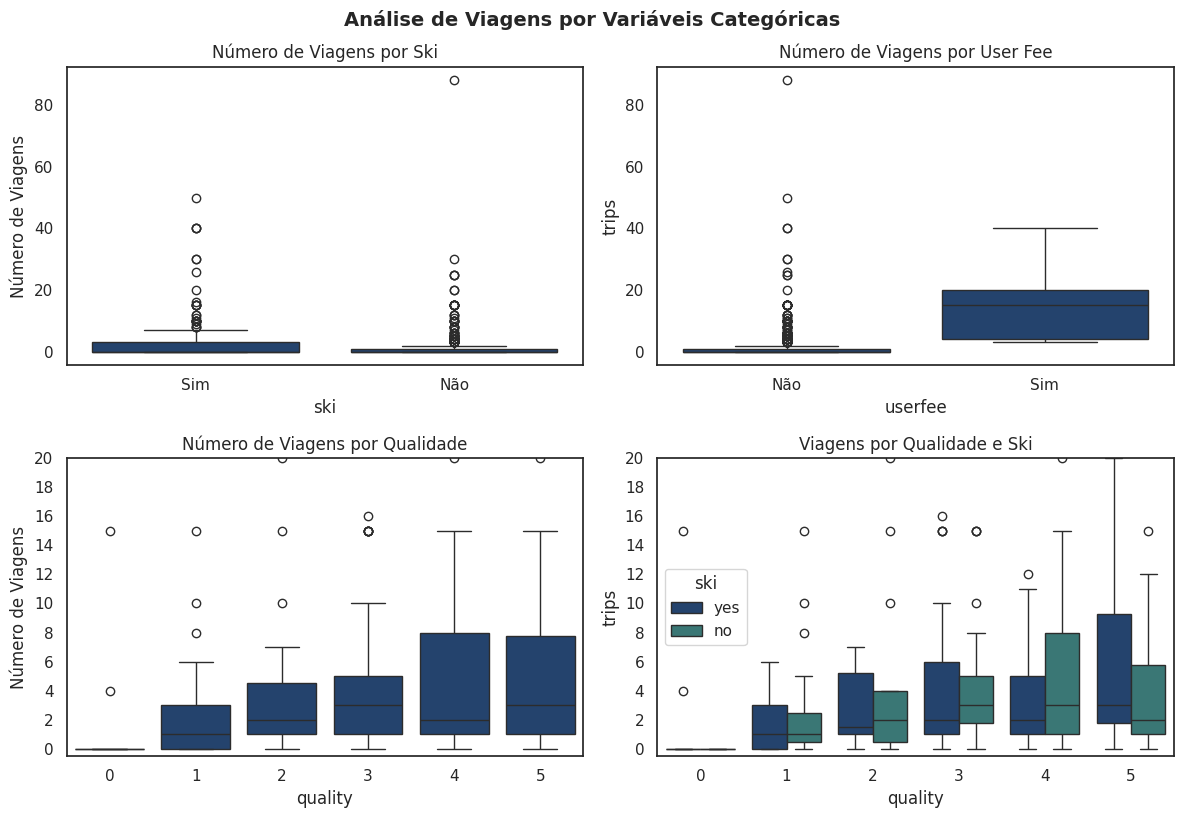

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.boxplot(x="ski", y="trips", data=data, ax=axes[0, 0])
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(["Sim", "Não"])
axes[0, 0].set_title("Número de Viagens por Ski")
axes[0, 0].set_ylabel("Número de Viagens")

sns.boxplot(x="userfee", y="trips", data=data, ax=axes[0, 1])
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(["Não", "Sim"])
axes[0, 1].set_title("Número de Viagens por User Fee")

sns.boxplot(x="quality", y="trips", data=data, ax=axes[1, 0])
axes[1, 0].set_title("Número de Viagens por Qualidade")
axes[1, 0].set_ylabel("Número de Viagens")
axes[1, 0].set_ylim(-0.5, 20)
axes[1, 0].set_yticks(range(0, 21, 2))

sns.boxplot(x="quality", y="trips", hue="ski", data=data, ax=axes[1, 1])
axes[1, 1].set_title("Viagens por Qualidade e Ski")
axes[1, 1].set_ylim(-0.5, 20)
axes[1, 1].set_yticks(range(0, 21, 2))

plt.tight_layout()
plt.suptitle("Análise de Viagens por Variáveis Categóricas", fontsize=14, fontweight="bold", y=1.02)

plt.savefig("images/boxplots_variaveis.png", dpi=300)

plt.show()

In [19]:
data_correlation.drop(columns=["income"], inplace=True)

data_correlation["quality_ski"] = data_correlation["quality"] * data_correlation["ski"]

data_correlation["quality_userfee"] = (
    data_correlation["quality"] * data_correlation["userfee"]
)

data_correlation["quality_cost_log"] = (
    data_correlation["quality"] * data_correlation["costS_log"]
)

data_correlation["cost_userfee_log"] = (
    data_correlation["costS_log"] * data_correlation["userfee"]
)

data_correlation["cost_ski_log"] = (
    data_correlation["costS_log"] * data_correlation["ski"]
)

In [20]:
correls = np.abs(data_correlation.corr()["trips"]).sort_values(ascending=False)
correls

trips               1.000000
quality             0.386351
quality_cost_log    0.324681
quality_userfee     0.285144
userfee             0.279107
quality_ski         0.260273
cost_userfee_log    0.243169
costS_log           0.222033
costS               0.123704
ski                 0.079041
cost_ski_log        0.055945
costC               0.042213
costH               0.020512
costH_log           0.019436
costC_log           0.017639
Name: trips, dtype: float64

Garantiremos o uso das variáveis quality, ski, userfee e costS (com log para maior correlação) pela alta correlação com a variável trips. Jogaremos fora as variáveis costC e costH e income por baixa correlação com a variável trips.

## 2. Análise do modelo de Poisson

In [21]:
poisson_model = smf.glm(
    formula="trips ~ 1",
    data=data_correlation,
    family=sm.families.Poisson(),
).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  trips   No. Observations:                  659
Model:                            GLM   Df Residuals:                      658
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2801.4
Date:                Fri, 30 May 2025   Deviance:                       4849.7
Time:                        16:39:09   Pearson chi2:                 1.16e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8084      0.026     31.089      0.0

In [22]:
preds = poisson_model.fittedvalues
np.mean((preds - data_correlation["trips"]) ** 2)

np.float64(39.535153506600565)

In [23]:
poisson_model = smf.glm(
    formula="trips ~ quality",
    data=data_correlation,
    family=sm.families.Poisson(),
).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  trips   No. Observations:                  659
Model:                            GLM   Df Residuals:                      657
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2023.7
Date:                Fri, 30 May 2025   Deviance:                       3294.4
Time:                        16:39:09   Pearson chi2:                 9.20e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9056
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5138      0.058     -8.933      0.0

In [24]:
preds = poisson_model.fittedvalues
np.mean((preds - data_correlation["trips"]) ** 2)

np.float64(35.77235389123517)

In [25]:
poisson_model = smf.glm(
    formula="trips ~ quality + ski + userfee + costS_log",
    data=data_correlation,
    family=sm.families.Poisson(),
).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  trips   No. Observations:                  659
Model:                            GLM   Df Residuals:                      654
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1650.5
Date:                Fri, 30 May 2025   Deviance:                       2548.0
Time:                        16:39:09   Pearson chi2:                 4.62e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9696
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7091      0.150     18.018      0.0

In [26]:
preds = poisson_model.fittedvalues
np.mean((preds - data_correlation["trips"]) ** 2)

np.float64(32.11294112190825)

In [27]:
selected_poisson_model = smf.glm(
    formula="trips ~ quality * costS_log * (userfee + ski)",
    data=data_correlation,
    family=sm.families.Poisson(),
).fit()

print(selected_poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  trips   No. Observations:                  659
Model:                            GLM   Df Residuals:                      647
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1527.1
Date:                Fri, 30 May 2025   Deviance:                       2301.0
Time:                        16:39:09   Pearson chi2:                 3.90e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9791
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

## 3. Teste de Sobredispersão

In [28]:
preds = selected_poisson_model.fittedvalues

In [29]:
preds_m = preds.mean()
preds_var = preds.var()

print(f"Média dos valores previstos: {preds_m:.2f}")
print(f"Variância dos valores previstos: {preds_var:.2f}")

Média dos valores previstos: 2.24
Variância dos valores previstos: 13.33


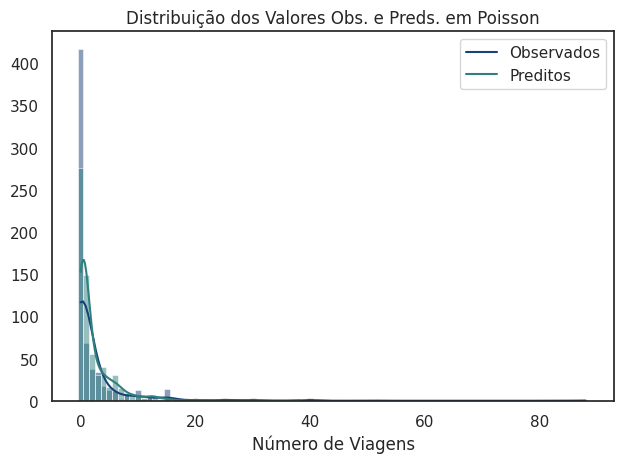

In [30]:
sns.histplot(
    data_correlation["trips"],
    kde=True,
    discrete=True,
)

sns.histplot(
    preds,
    kde=True,
    discrete=True,
)

plt.title("Distribuição dos Valores Obs. e Preds. em Poisson")
plt.xlabel("Número de Viagens")
plt.ylabel(None)
plt.legend(["Observados" , "Preditos"])
plt.tight_layout()
plt.show()

In [31]:
diff = data_correlation["trips"] - preds
diff = diff ** 2
diff -= data_correlation["trips"]

z_i = diff / preds

In [32]:
data_correlation["z_i"] = z_i
data_correlation["mu_hat"] = preds

data_test_ct = data_correlation[["z_i", "mu_hat"]].copy()

In [33]:
overdisp_test_model = smf.ols("z_i ~ mu_hat - 1", data=data_test_ct).fit()
print(overdisp_test_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    z_i   R-squared (uncentered):                   0.024
Model:                            OLS   Adj. R-squared (uncentered):              0.023
Method:                 Least Squares   F-statistic:                              16.17
Date:                Fri, 30 May 2025   Prob (F-statistic):                    6.44e-05
Time:                        16:39:09   Log-Likelihood:                         -3283.5
No. Observations:                 659   AIC:                                      6569.
Df Residuals:                     658   BIC:                                      6573.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## 4. Modelo Alternativo: Binomial Negativa

In [34]:
neg_binomial_model = smf.glm(
    formula="trips ~ quality * costS_log * (userfee + ski)",
    data=data_correlation,
    family=sm.families.NegativeBinomial(alpha=0.05),
).fit()
print(neg_binomial_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  trips   No. Observations:                  659
Model:                            GLM   Df Residuals:                      647
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1303.0
Date:                Fri, 30 May 2025   Deviance:                       1797.0
Time:                        16:39:09   Pearson chi2:                 3.29e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.9656
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [35]:
preds = neg_binomial_model.fittedvalues

In [36]:
np.mean((preds - data_correlation["trips"]) ** 2)

np.float64(27.42878844513426)

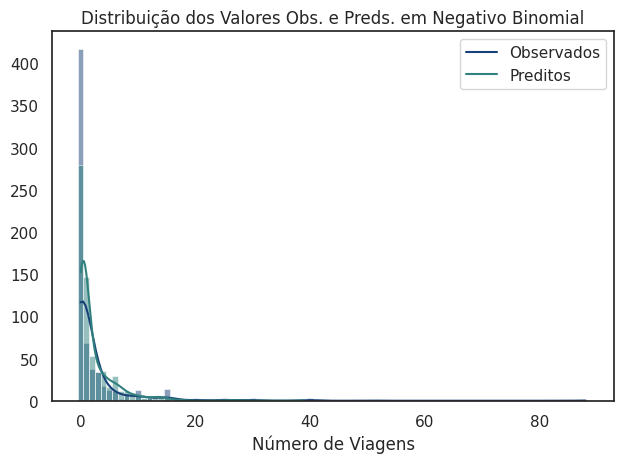

In [37]:
sns.histplot(
    data_correlation["trips"],
    kde=True,
    discrete=True,
)

sns.histplot(
    preds,
    kde=True,
    discrete=True,
)

plt.title("Distribuição dos Valores Obs. e Preds. em Negativo Binomial")
plt.xlabel("Número de Viagens")
plt.ylabel(None)
plt.legend(["Observados", "Preditos"])
plt.tight_layout()
plt.show()

## 5. Extra: Excesso de Zeros

In [38]:
zeros_count = data_correlation["trips"].value_counts()[0]
print(f"Contagem de zeros: {zeros_count}")
print(f"Proporção de zeros: {zeros_count / len(data_correlation):.2f}")

Contagem de zeros: 417
Proporção de zeros: 0.63


In [39]:
preds = selected_poisson_model.predict(data_correlation)

prob_zero_poisson = np.exp(-preds)
zeros_esperados_poisson = np.sum(prob_zero_poisson)

print(f"Contagem de zeros (Poisson): {zeros_esperados_poisson}")
print(f"Proporção de zeros (Poisson): {zeros_esperados_poisson / len(preds):.2f}")

Contagem de zeros (Poisson): 309.35920241695396
Proporção de zeros (Poisson): 0.47


In [40]:
data_correlation["intercept"] = 1
data_correlation["quality:costS_log"] = (
    data_correlation["quality"] * data_correlation["costS_log"]
)

data_correlation["quality:ski"] = (
    data_correlation["quality"] * data_correlation["ski"]
)
data_correlation["quality:userfee"] = (
    data_correlation["quality"] * data_correlation["userfee"]
)

data_correlation["costS_log:userfee"] = (
    data_correlation["costS_log"] * data_correlation["userfee"]
)
data_correlation["costS_log:ski"] = (
    data_correlation["costS_log"] * data_correlation["ski"]
)
data_correlation["quality:costS_log:userfee"] = (
    data_correlation["quality"]
    * data_correlation["costS_log"]
    * data_correlation["userfee"]
)
data_correlation["quality:costS_log:ski"] = (
    data_correlation["quality"]
    * data_correlation["costS_log"]
    * data_correlation["ski"]
)

In [41]:
cols = [
    "intercept",
    "quality",
    "ski",
    # "userfee",
    "costS_log",
    "quality:ski",
    "costS_log:userfee",
    "costS_log:ski",
]

zero_inf_pois = sm.ZeroInflatedPoisson(
    endog=data_correlation["trips"],
    exog=data_correlation[cols],
    exog_infl=data_correlation[["quality"]],
    inflation="logit",
).fit(maxiter=100, disp=True)

print(zero_inf_pois.summary())

Optimization terminated successfully.
         Current function value: 2.050341
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                   trips   No. Observations:                  659
Model:             ZeroInflatedPoisson   Df Residuals:                      652
Method:                            MLE   Df Model:                            6
Date:                 Fri, 30 May 2025   Pseudo R-squ.:                  0.2290
Time:                         16:39:10   Log-Likelihood:                -1351.2
converged:                        True   LL-Null:                       -1752.5
Covariance Type:             nonrobust   LLR p-value:                4.260e-170
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_quality 

In [42]:
preds = zero_inf_pois.fittedvalues

In [43]:
((preds - data_correlation["trips"]) ** 2).mean()

np.float64(102.68415023670184)

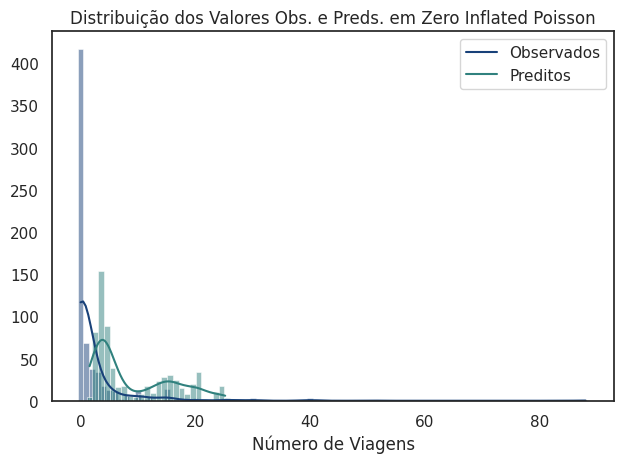

In [44]:
sns.histplot(
    data_correlation["trips"],
    kde=True,
    discrete=True,
)

sns.histplot(
    preds,
    kde=True,
    discrete=True,
)


plt.title("Distribuição dos Valores Obs. e Preds. em Zero Inflated Poisson")
plt.xlabel("Número de Viagens")
plt.ylabel(None)
plt.legend(["Observados", "Preditos"])
plt.tight_layout()
plt.show()

In [45]:
models = {
    "Poisson": [poisson_model.aic, poisson_model.bic_llf],
    "Negativo Binomial": [neg_binomial_model.aic, neg_binomial_model.bic_llf],
    "Zero Inflated Poisson": [zero_inf_pois.aic, zero_inf_pois.bic],
}

models_df = pd.DataFrame(models, index=["AIC", "BIC"]).T

print(models_df.sort_values(by="AIC"))

                               AIC          BIC
Negativo Binomial      2629.961995  2683.850677
Zero Inflated Poisson  2718.350034  2754.275823
Poisson                3311.068576  3333.522194


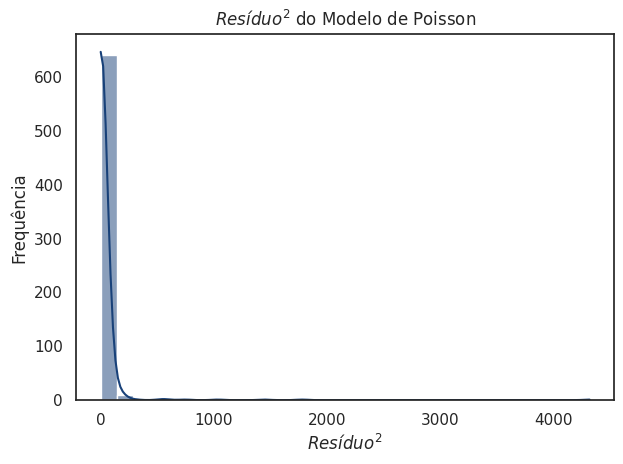

In [46]:
residuals = (data_correlation["trips"] - selected_poisson_model.fittedvalues) ** 2

sns.histplot(residuals, kde=True, bins=30)
plt.title("$Resíduo^2$ do Modelo de Poisson")
plt.xlabel("$Resíduo^2$")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

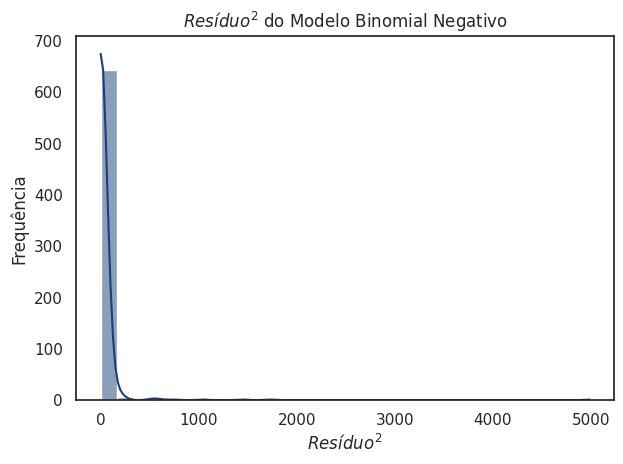

In [47]:
residuals = (data_correlation["trips"] - neg_binomial_model.fittedvalues) ** 2

sns.histplot(residuals, kde=True, bins=30)
plt.title("$Resíduo^2$ do Modelo Binomial Negativo")
plt.xlabel("$Resíduo^2$")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

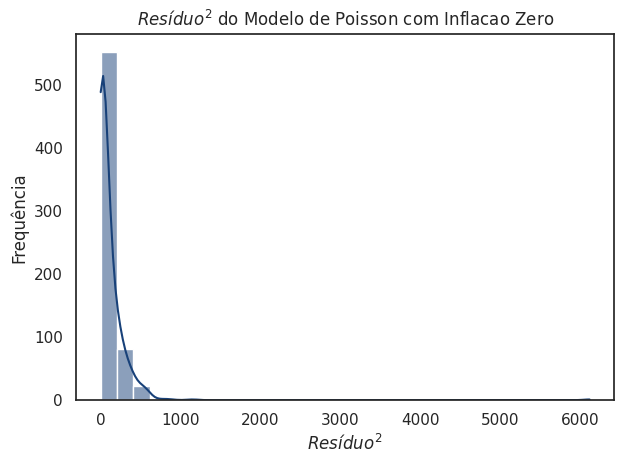

In [48]:
residuals = (data_correlation["trips"] - zero_inf_pois.fittedvalues) ** 2

sns.histplot(residuals, kde=True, bins=30)
plt.title("$Resíduo^2$ do Modelo de Poisson com Inflacao Zero")
plt.xlabel("$Resíduo^2$")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()